In [1]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, Dropout, GlobalAveragePooling2D,
                                    MaxPooling2D, Activation, Dense, Layer)
from tensorflow.keras.datasets import cifar10
from tensorflow.compat.v2.nn import local_response_normalization as lrn
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Model
import cca_core

In [2]:
'''
Obtain data as described in paper, 1000 images, 100 per category
'''
x_predict = np.empty((1000, 32, 32, 3))
y_predict = np.empty((1000, 1))

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


# Fill up 10 different categories with 100 images
full = False
# 10 different counters for the 10 categories
counts = [0] * 10
i = 0
while not full:
    print('Image', str(i))
    x = x_test[i]
    y = y_test[i] # also serves as index
    # Check if the category is full first, otherwise skip
    cur_count = counts[y[0]]
    if cur_count != 100:
        x_predict[100 * y[0] + cur_count] = x
        y_predict[100 * y[0] + cur_count] = y
        counts[y[0]] += 1
    print('Counts: ', counts)
    # Quit when all categories are full
    full = all(count == 100 for count in counts)
    i += 1

Image 0
Counts:  [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
Image 1
Counts:  [0, 0, 0, 1, 0, 0, 0, 0, 1, 0]
Image 2
Counts:  [0, 0, 0, 1, 0, 0, 0, 0, 2, 0]
Image 3
Counts:  [1, 0, 0, 1, 0, 0, 0, 0, 2, 0]
Image 4
Counts:  [1, 0, 0, 1, 0, 0, 1, 0, 2, 0]
Image 5
Counts:  [1, 0, 0, 1, 0, 0, 2, 0, 2, 0]
Image 6
Counts:  [1, 1, 0, 1, 0, 0, 2, 0, 2, 0]
Image 7
Counts:  [1, 1, 0, 1, 0, 0, 3, 0, 2, 0]
Image 8
Counts:  [1, 1, 0, 2, 0, 0, 3, 0, 2, 0]
Image 9
Counts:  [1, 2, 0, 2, 0, 0, 3, 0, 2, 0]
Image 10
Counts:  [2, 2, 0, 2, 0, 0, 3, 0, 2, 0]
Image 11
Counts:  [2, 2, 0, 2, 0, 0, 3, 0, 2, 1]
Image 12
Counts:  [2, 2, 0, 2, 0, 1, 3, 0, 2, 1]
Image 13
Counts:  [2, 2, 0, 2, 0, 1, 3, 1, 2, 1]
Image 14
Counts:  [2, 2, 0, 2, 0, 1, 3, 1, 2, 2]
Image 15
Counts:  [2, 2, 0, 2, 0, 1, 3, 1, 3, 2]
Image 16
Counts:  [2, 2, 0, 2, 0, 2, 3, 1, 3, 2]
Image 17
Counts:  [2, 2, 0, 2, 0, 2, 3, 2, 3, 2]
Image 18
Counts:  [2, 2, 0, 2, 0, 2, 3, 2, 4, 2]
Image 19
Counts:  [2, 2, 0, 2, 0, 2, 4, 2, 4, 2]
Image 20
Counts:  [2, 2, 0, 2,

Counts:  [73, 56, 69, 72, 64, 71, 84, 68, 81, 85]
Image 723
Counts:  [73, 57, 69, 72, 64, 71, 84, 68, 81, 85]
Image 724
Counts:  [73, 57, 69, 72, 64, 71, 84, 68, 82, 85]
Image 725
Counts:  [73, 57, 70, 72, 64, 71, 84, 68, 82, 85]
Image 726
Counts:  [73, 58, 70, 72, 64, 71, 84, 68, 82, 85]
Image 727
Counts:  [73, 58, 70, 73, 64, 71, 84, 68, 82, 85]
Image 728
Counts:  [73, 58, 70, 73, 64, 71, 85, 68, 82, 85]
Image 729
Counts:  [73, 58, 70, 73, 64, 72, 85, 68, 82, 85]
Image 730
Counts:  [73, 58, 70, 73, 65, 72, 85, 68, 82, 85]
Image 731
Counts:  [73, 58, 71, 73, 65, 72, 85, 68, 82, 85]
Image 732
Counts:  [73, 58, 71, 73, 65, 72, 85, 69, 82, 85]
Image 733
Counts:  [73, 58, 71, 73, 65, 72, 85, 69, 82, 86]
Image 734
Counts:  [73, 58, 71, 73, 65, 72, 85, 69, 82, 87]
Image 735
Counts:  [73, 58, 71, 73, 66, 72, 85, 69, 82, 87]
Image 736
Counts:  [73, 59, 71, 73, 66, 72, 85, 69, 82, 87]
Image 737
Counts:  [73, 59, 71, 73, 67, 72, 85, 69, 82, 87]
Image 738
Counts:  [73, 60, 71, 73, 67, 72, 85, 69

In [6]:
'''
SVCCA Pt. 1: Get flattened representations by avg pooling
'''

# For SVCCA, 1. prep data by avg pooling, 2. find threshold for each layer of each network
# 3. SVCCA each network with each other network, plot into graph


# Helper function to find threshold for each layer            
def search_threshold(acts):
    print('Getting threshold...')
    target = 0.99
    start = 0
    end = acts.shape[0]
    ans = -1
    while start <= end:
        mid = (start + end) // 2
        # Move to right side if target is 
        # greater. 
        s = np.linalg.svd(acts - np.mean(acts, axis=1, keepdims=True), full_matrices=False)[1]
        # Note: normally comparing floating points is a bad bad but the precision we need is low enough
        if (np.sum(s[:mid])/np.sum(s) <= target): 
            start = mid + 1;
        # Move left side. 
        else: 
            ans = mid; 
            end = mid - 1;
    # Prevent silent failure
    if ans == -1:
        raise
    print('Sanity check, achieved', np.sum(s[:ans])/np.sum(s), 'variance with', ans, 'neurons')
    return ans

num_images = len(x_predict) # 1000
num_networks = 10
num_layers = 9
rep_list = [] #end result shape = (networks * layers, (imgs, neurons))
thresholds = np.empty((num_networks * num_layers))

# Loop through network instances
for i in range(num_networks):
    print('Working on model', str(i))
    K.clear_session()
    full_model = load_model('Primary/all_cnn_c_' + str(i) + '.h5')
    inp = full_model.input
    # Loop through layers
    for j in range(num_layers):
        print('Layer', str(j))
        out = full_model.layers[j + 1].output
        temp_model = Model(inputs=inp, outputs=out)
        # Predict on x_predict
        print('Getting representation...')
        representations = temp_model.predict(x_predict)
        print('Old shape:', representations.shape)
        # Average pool along spacial dimensions, transpose to fit shape (imgs, neurons)
        if (len(representations.shape) > 2):
            avg = np.mean(representations, axis=(1,2)).T
            print('Avg shape:', avg.shape)
        else:
            avg = representations.T
            print('No need to flatten')
        # Note that ordering is backwards from RSA, need to readjust down the line
        rep_list.append(avg)
        thresholds[num_layers * i + j] = search_threshold(avg)

Working on model 0
Layer 0
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, achieved 0.9900402 variance with 68 neurons
Layer 1
Getting representation...
Old shape: (1000, 16, 16, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, achieved 0.99009836 variance with 76 neurons
Layer 2
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.9902922 variance with 172 neurons
Layer 3
Getting representation...
Old shape: (1000, 16, 16, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.9901531 variance with 178 neurons
Layer 4
Getting representation...
Old shape: (1000, 8, 8, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.9906471 variance with 184 neurons
Layer 5
Getting representation...
Old shape: (1000, 8, 8, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.99083894 varianc

Sanity check, achieved 0.9911421 variance with 185 neurons
Layer 5
Getting representation...
Old shape: (1000, 8, 8, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.9909963 variance with 185 neurons
Layer 6
Getting representation...
Old shape: (1000, 8, 8, 192)
Avg shape: (192, 1000)
Getting threshold...
Sanity check, achieved 0.990367 variance with 183 neurons
Layer 7
Getting representation...
Old shape: (1000, 8, 8, 10)
Avg shape: (10, 1000)
Getting threshold...
Sanity check, achieved 1.0 variance with 10 neurons
Layer 8
Getting representation...
Old shape: (1000, 10)
No need to flatten
Getting threshold...
Sanity check, achieved 1.0 variance with 10 neurons
Working on model 6
Layer 0
Getting representation...
Old shape: (1000, 32, 32, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, achieved 0.9905517 variance with 73 neurons
Layer 1
Getting representation...
Old shape: (1000, 16, 16, 96)
Avg shape: (96, 1000)
Getting threshold...
Sanity check, 

In [7]:
'''
SVCCA Pt. 2: Run SVCCA on every pairing of flattened representations (90 total) and save results
'''

# Helper Function for svcca
def svcca(acts1, acts2, threshold1, threshold2):
    print('Running SVCCA...')

    # Mean subtract activations
    cacts1 = acts1 - np.mean(acts1, axis=1, keepdims=True)
    cacts2 = acts2 - np.mean(acts2, axis=1, keepdims=True)

    # Perform SVD
    U1, s1, V1 = np.linalg.svd(cacts1, full_matrices=False)
    U2, s2, V2 = np.linalg.svd(cacts2, full_matrices=False)
    svacts1 = np.dot(s1[:threshold1]*np.eye(threshold1), V1[:threshold1])
    svacts2 = np.dot(s2[:threshold2]*np.eye(threshold2), V2[:threshold2])
    print('acts1 shape:', svacts1.shape)
    print('acts2 shape:', svacts2.shape)
    svcca_results = cca_core.get_cca_similarity(svacts1, svacts2, epsilon=1e-10, verbose=False)['cca_coef1']
    return np.mean(svcca_results)
     
print('Done preprocessing representations and thresholds, now CCA')
cca_correlations = np.empty((num_layers * num_networks, num_layers * num_networks))
for i in range(cca_correlations.shape[0]):
    for j in range(cca_correlations.shape[1]):
        print('Correlation', str(i), ',', str(j))
        # Interface between layer*network and network*layer
        layer_i   = i // num_networks
        network_i = i % num_networks
        layer_j   = j // num_networks
        network_j = j % num_networks
        # Logic: Consider num = 57. For cca_correlations, this means layer 5 of network 7.
        # For rep_list, this means layer 3 of network 6. Layer 5 of network 7 in rep_list is 68
        
        acts1 = rep_list[num_layers * network_i + layer_i]
        acts2 = rep_list[num_layers * network_j + layer_j]
        
        # Get highest threshold of the 2
        thresh1 = int(thresholds[num_layers * network_i + layer_i])
        thresh2 = int(thresholds[num_layers * network_j + layer_j])
        
        # Do svcca
        print('Thresholds:', str(thresh1), str(thresh2))
        cca_correlations[i, j] = svcca(acts1, acts2, thresh1, thresh2)

np.save('cca_correlations.npy', cca_correlations)
print('Done!')

Done preprocessing representations and thresholds, now CCA
Correlation 0 , 0
Thresholds: 68 68
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (68, 1000)
Correlation 0 , 1
Thresholds: 68 68
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (68, 1000)
Correlation 0 , 2
Thresholds: 68 61
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (61, 1000)
Correlation 0 , 3
Thresholds: 68 67
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (67, 1000)
Correlation 0 , 4
Thresholds: 68 71
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (71, 1000)
Correlation 0 , 5
Thresholds: 68 73
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (73, 1000)
Correlation 0 , 6
Thresholds: 68 73
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (73, 1000)
Correlation 0 , 7
Thresholds: 68 70
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (70, 1000)
Correlation 0 , 8
Thresholds: 68 70
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (70, 1000)
Correlation 0 , 9
Thresholds: 68

acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 0 , 81
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 0 , 82
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 0 , 83
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 0 , 84
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 0 , 85
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 0 , 86
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 0 , 87
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 0 , 88
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 0 , 89
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 0
Thresholds: 68 6

acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 73
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 74
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 75
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 76
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 77
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 78
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 79
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 80
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 81
Thresholds: 68 10
Running SVCCA...
acts1 shape: (68, 1000)
acts2 shape: (10, 1000)
Correlation 1 , 82
Thresholds: 68 

acts1 shape: (61, 1000)
acts2 shape: (184, 1000)
Correlation 2 , 63
Thresholds: 61 183
Running SVCCA...
acts1 shape: (61, 1000)
acts2 shape: (183, 1000)
Correlation 2 , 64
Thresholds: 61 185
Running SVCCA...
acts1 shape: (61, 1000)
acts2 shape: (185, 1000)
Correlation 2 , 65
Thresholds: 61 183
Running SVCCA...
acts1 shape: (61, 1000)
acts2 shape: (183, 1000)
Correlation 2 , 66
Thresholds: 61 184
Running SVCCA...
acts1 shape: (61, 1000)
acts2 shape: (184, 1000)
Correlation 2 , 67
Thresholds: 61 185
Running SVCCA...
acts1 shape: (61, 1000)
acts2 shape: (185, 1000)
Correlation 2 , 68
Thresholds: 61 184
Running SVCCA...
acts1 shape: (61, 1000)
acts2 shape: (184, 1000)
Correlation 2 , 69
Thresholds: 61 183
Running SVCCA...
acts1 shape: (61, 1000)
acts2 shape: (183, 1000)
Correlation 2 , 70
Thresholds: 61 10
Running SVCCA...
acts1 shape: (61, 1000)
acts2 shape: (10, 1000)
Correlation 2 , 71
Thresholds: 61 10
Running SVCCA...
acts1 shape: (61, 1000)
acts2 shape: (10, 1000)
Correlation 2 , 72


acts1 shape: (67, 1000)
acts2 shape: (186, 1000)
Correlation 3 , 53
Thresholds: 67 185
Running SVCCA...
acts1 shape: (67, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 54
Thresholds: 67 185
Running SVCCA...
acts1 shape: (67, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 55
Thresholds: 67 185
Running SVCCA...
acts1 shape: (67, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 56
Thresholds: 67 185
Running SVCCA...
acts1 shape: (67, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 57
Thresholds: 67 185
Running SVCCA...
acts1 shape: (67, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 58
Thresholds: 67 185
Running SVCCA...
acts1 shape: (67, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 59
Thresholds: 67 185
Running SVCCA...
acts1 shape: (67, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 60
Thresholds: 67 185
Running SVCCA...
acts1 shape: (67, 1000)
acts2 shape: (185, 1000)
Correlation 3 , 61
Thresholds: 67 183
Running SVCCA...
acts1 shape: (67, 1000)
acts2 shape: (183, 1000)
Correlation 3 ,

acts1 shape: (71, 1000)
acts2 shape: (185, 1000)
Correlation 4 , 43
Thresholds: 71 185
Running SVCCA...
acts1 shape: (71, 1000)
acts2 shape: (185, 1000)
Correlation 4 , 44
Thresholds: 71 183
Running SVCCA...
acts1 shape: (71, 1000)
acts2 shape: (183, 1000)
Correlation 4 , 45
Thresholds: 71 185
Running SVCCA...
acts1 shape: (71, 1000)
acts2 shape: (185, 1000)
Correlation 4 , 46
Thresholds: 71 184
Running SVCCA...
acts1 shape: (71, 1000)
acts2 shape: (184, 1000)
Correlation 4 , 47
Thresholds: 71 184
Running SVCCA...
acts1 shape: (71, 1000)
acts2 shape: (184, 1000)
Correlation 4 , 48
Thresholds: 71 184
Running SVCCA...
acts1 shape: (71, 1000)
acts2 shape: (184, 1000)
Correlation 4 , 49
Thresholds: 71 185
Running SVCCA...
acts1 shape: (71, 1000)
acts2 shape: (185, 1000)
Correlation 4 , 50
Thresholds: 71 186
Running SVCCA...
acts1 shape: (71, 1000)
acts2 shape: (186, 1000)
Correlation 4 , 51
Thresholds: 71 185
Running SVCCA...
acts1 shape: (71, 1000)
acts2 shape: (185, 1000)
Correlation 4 ,

acts1 shape: (73, 1000)
acts2 shape: (182, 1000)
Correlation 5 , 33
Thresholds: 73 181
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (181, 1000)
Correlation 5 , 34
Thresholds: 73 178
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (178, 1000)
Correlation 5 , 35
Thresholds: 73 181
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (181, 1000)
Correlation 5 , 36
Thresholds: 73 181
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (181, 1000)
Correlation 5 , 37
Thresholds: 73 181
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (181, 1000)
Correlation 5 , 38
Thresholds: 73 181
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (181, 1000)
Correlation 5 , 39
Thresholds: 73 181
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (181, 1000)
Correlation 5 , 40
Thresholds: 73 184
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (184, 1000)
Correlation 5 , 41
Thresholds: 73 184
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (184, 1000)
Correlation 5 ,

Correlation 6 , 23
Thresholds: 73 176
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (176, 1000)
Correlation 6 , 24
Thresholds: 73 171
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (171, 1000)
Correlation 6 , 25
Thresholds: 73 178
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (178, 1000)
Correlation 6 , 26
Thresholds: 73 176
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (176, 1000)
Correlation 6 , 27
Thresholds: 73 176
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (176, 1000)
Correlation 6 , 28
Thresholds: 73 176
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (176, 1000)
Correlation 6 , 29
Thresholds: 73 178
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (178, 1000)
Correlation 6 , 30
Thresholds: 73 178
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (178, 1000)
Correlation 6 , 31
Thresholds: 73 180
Running SVCCA...
acts1 shape: (73, 1000)
acts2 shape: (180, 1000)
Correlation 6 , 32
Thresholds: 73 182
Running SVCCA...
acts1 sha

acts1 shape: (70, 1000)
acts2 shape: (75, 1000)
Correlation 7 , 13
Thresholds: 70 80
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (80, 1000)
Correlation 7 , 14
Thresholds: 70 78
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (78, 1000)
Correlation 7 , 15
Thresholds: 70 81
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (81, 1000)
Correlation 7 , 16
Thresholds: 70 80
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (80, 1000)
Correlation 7 , 17
Thresholds: 70 81
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (81, 1000)
Correlation 7 , 18
Thresholds: 70 78
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (78, 1000)
Correlation 7 , 19
Thresholds: 70 78
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (78, 1000)
Correlation 7 , 20
Thresholds: 70 172
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (172, 1000)
Correlation 7 , 21
Thresholds: 70 178
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (178, 1000)
Correlation 7 , 22
Thresholds:

acts1 shape: (70, 1000)
acts2 shape: (67, 1000)
Correlation 8 , 4
Thresholds: 70 71
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (71, 1000)
Correlation 8 , 5
Thresholds: 70 73
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (73, 1000)
Correlation 8 , 6
Thresholds: 70 73
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (73, 1000)
Correlation 8 , 7
Thresholds: 70 70
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (70, 1000)
Correlation 8 , 8
Thresholds: 70 70
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (70, 1000)
Correlation 8 , 9
Thresholds: 70 69
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (69, 1000)
Correlation 8 , 10
Thresholds: 70 76
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (76, 1000)
Correlation 8 , 11
Thresholds: 70 81
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (81, 1000)
Correlation 8 , 12
Thresholds: 70 75
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (75, 1000)
Correlation 8 , 13
Thresholds: 70 80
Run

acts1 shape: (70, 1000)
acts2 shape: (10, 1000)
Correlation 8 , 85
Thresholds: 70 10
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (10, 1000)
Correlation 8 , 86
Thresholds: 70 10
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (10, 1000)
Correlation 8 , 87
Thresholds: 70 10
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (10, 1000)
Correlation 8 , 88
Thresholds: 70 10
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (10, 1000)
Correlation 8 , 89
Thresholds: 70 10
Running SVCCA...
acts1 shape: (70, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 0
Thresholds: 69 68
Running SVCCA...
acts1 shape: (69, 1000)
acts2 shape: (68, 1000)
Correlation 9 , 1
Thresholds: 69 68
Running SVCCA...
acts1 shape: (69, 1000)
acts2 shape: (68, 1000)
Correlation 9 , 2
Thresholds: 69 61
Running SVCCA...
acts1 shape: (69, 1000)
acts2 shape: (61, 1000)
Correlation 9 , 3
Thresholds: 69 67
Running SVCCA...
acts1 shape: (69, 1000)
acts2 shape: (67, 1000)
Correlation 9 , 4
Thresholds: 69 71
Ru

acts1 shape: (69, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 76
Thresholds: 69 10
Running SVCCA...
acts1 shape: (69, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 77
Thresholds: 69 10
Running SVCCA...
acts1 shape: (69, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 78
Thresholds: 69 10
Running SVCCA...
acts1 shape: (69, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 79
Thresholds: 69 10
Running SVCCA...
acts1 shape: (69, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 80
Thresholds: 69 10
Running SVCCA...
acts1 shape: (69, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 81
Thresholds: 69 10
Running SVCCA...
acts1 shape: (69, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 82
Thresholds: 69 10
Running SVCCA...
acts1 shape: (69, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 83
Thresholds: 69 10
Running SVCCA...
acts1 shape: (69, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 84
Thresholds: 69 10
Running SVCCA...
acts1 shape: (69, 1000)
acts2 shape: (10, 1000)
Correlation 9 , 85
Thresholds: 69 

Correlation 10 , 65
Thresholds: 76 183
Running SVCCA...
acts1 shape: (76, 1000)
acts2 shape: (183, 1000)
Correlation 10 , 66
Thresholds: 76 184
Running SVCCA...
acts1 shape: (76, 1000)
acts2 shape: (184, 1000)
Correlation 10 , 67
Thresholds: 76 185
Running SVCCA...
acts1 shape: (76, 1000)
acts2 shape: (185, 1000)
Correlation 10 , 68
Thresholds: 76 184
Running SVCCA...
acts1 shape: (76, 1000)
acts2 shape: (184, 1000)
Correlation 10 , 69
Thresholds: 76 183
Running SVCCA...
acts1 shape: (76, 1000)
acts2 shape: (183, 1000)
Correlation 10 , 70
Thresholds: 76 10
Running SVCCA...
acts1 shape: (76, 1000)
acts2 shape: (10, 1000)
Correlation 10 , 71
Thresholds: 76 10
Running SVCCA...
acts1 shape: (76, 1000)
acts2 shape: (10, 1000)
Correlation 10 , 72
Thresholds: 76 10
Running SVCCA...
acts1 shape: (76, 1000)
acts2 shape: (10, 1000)
Correlation 10 , 73
Thresholds: 76 10
Running SVCCA...
acts1 shape: (76, 1000)
acts2 shape: (10, 1000)
Correlation 10 , 74
Thresholds: 76 10
Running SVCCA...
acts1 sh

acts1 shape: (81, 1000)
acts2 shape: (185, 1000)
Correlation 11 , 55
Thresholds: 81 185
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (185, 1000)
Correlation 11 , 56
Thresholds: 81 185
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (185, 1000)
Correlation 11 , 57
Thresholds: 81 185
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (185, 1000)
Correlation 11 , 58
Thresholds: 81 185
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (185, 1000)
Correlation 11 , 59
Thresholds: 81 185
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (185, 1000)
Correlation 11 , 60
Thresholds: 81 185
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (185, 1000)
Correlation 11 , 61
Thresholds: 81 183
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (183, 1000)
Correlation 11 , 62
Thresholds: 81 184
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (184, 1000)
Correlation 11 , 63
Thresholds: 81 183
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (183, 1000)
Correl

acts1 shape: (75, 1000)
acts2 shape: (185, 1000)
Correlation 12 , 44
Thresholds: 75 183
Running SVCCA...
acts1 shape: (75, 1000)
acts2 shape: (183, 1000)
Correlation 12 , 45
Thresholds: 75 185
Running SVCCA...
acts1 shape: (75, 1000)
acts2 shape: (185, 1000)
Correlation 12 , 46
Thresholds: 75 184
Running SVCCA...
acts1 shape: (75, 1000)
acts2 shape: (184, 1000)
Correlation 12 , 47
Thresholds: 75 184
Running SVCCA...
acts1 shape: (75, 1000)
acts2 shape: (184, 1000)
Correlation 12 , 48
Thresholds: 75 184
Running SVCCA...
acts1 shape: (75, 1000)
acts2 shape: (184, 1000)
Correlation 12 , 49
Thresholds: 75 185
Running SVCCA...
acts1 shape: (75, 1000)
acts2 shape: (185, 1000)
Correlation 12 , 50
Thresholds: 75 186
Running SVCCA...
acts1 shape: (75, 1000)
acts2 shape: (186, 1000)
Correlation 12 , 51
Thresholds: 75 185
Running SVCCA...
acts1 shape: (75, 1000)
acts2 shape: (185, 1000)
Correlation 12 , 52
Thresholds: 75 186
Running SVCCA...
acts1 shape: (75, 1000)
acts2 shape: (186, 1000)
Correl

acts1 shape: (80, 1000)
acts2 shape: (182, 1000)
Correlation 13 , 33
Thresholds: 80 181
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (181, 1000)
Correlation 13 , 34
Thresholds: 80 178
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (178, 1000)
Correlation 13 , 35
Thresholds: 80 181
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (181, 1000)
Correlation 13 , 36
Thresholds: 80 181
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (181, 1000)
Correlation 13 , 37
Thresholds: 80 181
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (181, 1000)
Correlation 13 , 38
Thresholds: 80 181
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (181, 1000)
Correlation 13 , 39
Thresholds: 80 181
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (181, 1000)
Correlation 13 , 40
Thresholds: 80 184
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (184, 1000)
Correlation 13 , 41
Thresholds: 80 184
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (184, 1000)
Correl

Correlation 14 , 22
Thresholds: 78 177
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (177, 1000)
Correlation 14 , 23
Thresholds: 78 176
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (176, 1000)
Correlation 14 , 24
Thresholds: 78 171
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (171, 1000)
Correlation 14 , 25
Thresholds: 78 178
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (178, 1000)
Correlation 14 , 26
Thresholds: 78 176
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (176, 1000)
Correlation 14 , 27
Thresholds: 78 176
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (176, 1000)
Correlation 14 , 28
Thresholds: 78 176
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (176, 1000)
Correlation 14 , 29
Thresholds: 78 178
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (178, 1000)
Correlation 14 , 30
Thresholds: 78 178
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (178, 1000)
Correlation 14 , 31
Thresholds: 78 180
Running SVCCA...

Correlation 15 , 11
Thresholds: 81 81
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (81, 1000)
Correlation 15 , 12
Thresholds: 81 75
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (75, 1000)
Correlation 15 , 13
Thresholds: 81 80
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (80, 1000)
Correlation 15 , 14
Thresholds: 81 78
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (78, 1000)
Correlation 15 , 15
Thresholds: 81 81
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (81, 1000)
Correlation 15 , 16
Thresholds: 81 80
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (80, 1000)
Correlation 15 , 17
Thresholds: 81 81
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (81, 1000)
Correlation 15 , 18
Thresholds: 81 78
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (78, 1000)
Correlation 15 , 19
Thresholds: 81 78
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (78, 1000)
Correlation 15 , 20
Thresholds: 81 172
Running SVCCA...
acts1 shape: (81,

acts1 shape: (80, 1000)
acts2 shape: (68, 1000)
Correlation 16 , 2
Thresholds: 80 61
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (61, 1000)
Correlation 16 , 3
Thresholds: 80 67
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (67, 1000)
Correlation 16 , 4
Thresholds: 80 71
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (71, 1000)
Correlation 16 , 5
Thresholds: 80 73
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (73, 1000)
Correlation 16 , 6
Thresholds: 80 73
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (73, 1000)
Correlation 16 , 7
Thresholds: 80 70
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (70, 1000)
Correlation 16 , 8
Thresholds: 80 70
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (70, 1000)
Correlation 16 , 9
Thresholds: 80 69
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (69, 1000)
Correlation 16 , 10
Thresholds: 80 76
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (76, 1000)
Correlation 16 , 11
Thresholds: 8

acts1 shape: (80, 1000)
acts2 shape: (10, 1000)
Correlation 16 , 83
Thresholds: 80 10
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (10, 1000)
Correlation 16 , 84
Thresholds: 80 10
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (10, 1000)
Correlation 16 , 85
Thresholds: 80 10
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (10, 1000)
Correlation 16 , 86
Thresholds: 80 10
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (10, 1000)
Correlation 16 , 87
Thresholds: 80 10
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (10, 1000)
Correlation 16 , 88
Thresholds: 80 10
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (10, 1000)
Correlation 16 , 89
Thresholds: 80 10
Running SVCCA...
acts1 shape: (80, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 0
Thresholds: 81 68
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (68, 1000)
Correlation 17 , 1
Thresholds: 81 68
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (68, 1000)
Correlation 17 , 2
Threshol

acts1 shape: (81, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 74
Thresholds: 81 10
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 75
Thresholds: 81 10
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 76
Thresholds: 81 10
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 77
Thresholds: 81 10
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 78
Thresholds: 81 10
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 79
Thresholds: 81 10
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 80
Thresholds: 81 10
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 81
Thresholds: 81 10
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 82
Thresholds: 81 10
Running SVCCA...
acts1 shape: (81, 1000)
acts2 shape: (10, 1000)
Correlation 17 , 83
Thres

acts1 shape: (78, 1000)
acts2 shape: (184, 1000)
Correlation 18 , 63
Thresholds: 78 183
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (183, 1000)
Correlation 18 , 64
Thresholds: 78 185
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (185, 1000)
Correlation 18 , 65
Thresholds: 78 183
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (183, 1000)
Correlation 18 , 66
Thresholds: 78 184
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (184, 1000)
Correlation 18 , 67
Thresholds: 78 185
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (185, 1000)
Correlation 18 , 68
Thresholds: 78 184
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (184, 1000)
Correlation 18 , 69
Thresholds: 78 183
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (183, 1000)
Correlation 18 , 70
Thresholds: 78 10
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (10, 1000)
Correlation 18 , 71
Thresholds: 78 10
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (10, 1000)
Correlatio

acts1 shape: (78, 1000)
acts2 shape: (185, 1000)
Correlation 19 , 52
Thresholds: 78 186
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (186, 1000)
Correlation 19 , 53
Thresholds: 78 185
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (185, 1000)
Correlation 19 , 54
Thresholds: 78 185
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (185, 1000)
Correlation 19 , 55
Thresholds: 78 185
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (185, 1000)
Correlation 19 , 56
Thresholds: 78 185
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (185, 1000)
Correlation 19 , 57
Thresholds: 78 185
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (185, 1000)
Correlation 19 , 58
Thresholds: 78 185
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (185, 1000)
Correlation 19 , 59
Thresholds: 78 185
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (185, 1000)
Correlation 19 , 60
Thresholds: 78 185
Running SVCCA...
acts1 shape: (78, 1000)
acts2 shape: (185, 1000)
Correl

acts1 shape: (172, 1000)
acts2 shape: (184, 1000)
Correlation 20 , 41
Thresholds: 172 184
Running SVCCA...
acts1 shape: (172, 1000)
acts2 shape: (184, 1000)
Correlation 20 , 42
Thresholds: 172 185
Running SVCCA...
acts1 shape: (172, 1000)
acts2 shape: (185, 1000)
Correlation 20 , 43
Thresholds: 172 185
Running SVCCA...
acts1 shape: (172, 1000)
acts2 shape: (185, 1000)
Correlation 20 , 44
Thresholds: 172 183
Running SVCCA...
acts1 shape: (172, 1000)
acts2 shape: (183, 1000)
Correlation 20 , 45
Thresholds: 172 185
Running SVCCA...
acts1 shape: (172, 1000)
acts2 shape: (185, 1000)
Correlation 20 , 46
Thresholds: 172 184
Running SVCCA...
acts1 shape: (172, 1000)
acts2 shape: (184, 1000)
Correlation 20 , 47
Thresholds: 172 184
Running SVCCA...
acts1 shape: (172, 1000)
acts2 shape: (184, 1000)
Correlation 20 , 48
Thresholds: 172 184
Running SVCCA...
acts1 shape: (172, 1000)
acts2 shape: (184, 1000)
Correlation 20 , 49
Thresholds: 172 185
Running SVCCA...
acts1 shape: (172, 1000)
acts2 shape:

acts1 shape: (178, 1000)
acts2 shape: (176, 1000)
Correlation 21 , 29
Thresholds: 178 178
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (178, 1000)
Correlation 21 , 30
Thresholds: 178 178
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (178, 1000)
Correlation 21 , 31
Thresholds: 178 180
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (180, 1000)
Correlation 21 , 32
Thresholds: 178 182
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (182, 1000)
Correlation 21 , 33
Thresholds: 178 181
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (181, 1000)
Correlation 21 , 34
Thresholds: 178 178
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (178, 1000)
Correlation 21 , 35
Thresholds: 178 181
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (181, 1000)
Correlation 21 , 36
Thresholds: 178 181
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (181, 1000)
Correlation 21 , 37
Thresholds: 178 181
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape:

acts1 shape: (177, 1000)
acts2 shape: (80, 1000)
Correlation 22 , 17
Thresholds: 177 81
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (81, 1000)
Correlation 22 , 18
Thresholds: 177 78
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (78, 1000)
Correlation 22 , 19
Thresholds: 177 78
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (78, 1000)
Correlation 22 , 20
Thresholds: 177 172
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (172, 1000)
Correlation 22 , 21
Thresholds: 177 178
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (178, 1000)
Correlation 22 , 22
Thresholds: 177 177
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (177, 1000)
Correlation 22 , 23
Thresholds: 177 176
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (176, 1000)
Correlation 22 , 24
Thresholds: 177 171
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (171, 1000)
Correlation 22 , 25
Thresholds: 177 178
Running SVCCA...
acts1 shape: (177, 1000)
acts2 shape: (178, 

Correlation 23 , 4
Thresholds: 176 71
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (71, 1000)
Correlation 23 , 5
Thresholds: 176 73
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (73, 1000)
Correlation 23 , 6
Thresholds: 176 73
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (73, 1000)
Correlation 23 , 7
Thresholds: 176 70
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (70, 1000)
Correlation 23 , 8
Thresholds: 176 70
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (70, 1000)
Correlation 23 , 9
Thresholds: 176 69
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (69, 1000)
Correlation 23 , 10
Thresholds: 176 76
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (76, 1000)
Correlation 23 , 11
Thresholds: 176 81
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (81, 1000)
Correlation 23 , 12
Thresholds: 176 75
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (75, 1000)
Correlation 23 , 13
Thresholds: 176 80
Running SVCCA...
acts1

acts1 shape: (176, 1000)
acts2 shape: (10, 1000)
Correlation 23 , 83
Thresholds: 176 10
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (10, 1000)
Correlation 23 , 84
Thresholds: 176 10
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (10, 1000)
Correlation 23 , 85
Thresholds: 176 10
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (10, 1000)
Correlation 23 , 86
Thresholds: 176 10
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (10, 1000)
Correlation 23 , 87
Thresholds: 176 10
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (10, 1000)
Correlation 23 , 88
Thresholds: 176 10
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (10, 1000)
Correlation 23 , 89
Thresholds: 176 10
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (10, 1000)
Correlation 24 , 0
Thresholds: 171 68
Running SVCCA...
acts1 shape: (171, 1000)
acts2 shape: (68, 1000)
Correlation 24 , 1
Thresholds: 171 68
Running SVCCA...
acts1 shape: (171, 1000)
acts2 shape: (68, 1000)
Correlat

acts1 shape: (171, 1000)
acts2 shape: (10, 1000)
Correlation 24 , 71
Thresholds: 171 10
Running SVCCA...
acts1 shape: (171, 1000)
acts2 shape: (10, 1000)
Correlation 24 , 72
Thresholds: 171 10
Running SVCCA...
acts1 shape: (171, 1000)
acts2 shape: (10, 1000)
Correlation 24 , 73
Thresholds: 171 10
Running SVCCA...
acts1 shape: (171, 1000)
acts2 shape: (10, 1000)
Correlation 24 , 74
Thresholds: 171 10
Running SVCCA...
acts1 shape: (171, 1000)
acts2 shape: (10, 1000)
Correlation 24 , 75
Thresholds: 171 10
Running SVCCA...
acts1 shape: (171, 1000)
acts2 shape: (10, 1000)
Correlation 24 , 76
Thresholds: 171 10
Running SVCCA...
acts1 shape: (171, 1000)
acts2 shape: (10, 1000)
Correlation 24 , 77
Thresholds: 171 10
Running SVCCA...
acts1 shape: (171, 1000)
acts2 shape: (10, 1000)
Correlation 24 , 78
Thresholds: 171 10
Running SVCCA...
acts1 shape: (171, 1000)
acts2 shape: (10, 1000)
Correlation 24 , 79
Thresholds: 171 10
Running SVCCA...
acts1 shape: (171, 1000)
acts2 shape: (10, 1000)
Correl

acts1 shape: (178, 1000)
acts2 shape: (185, 1000)
Correlation 25 , 59
Thresholds: 178 185
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (185, 1000)
Correlation 25 , 60
Thresholds: 178 185
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (185, 1000)
Correlation 25 , 61
Thresholds: 178 183
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (183, 1000)
Correlation 25 , 62
Thresholds: 178 184
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (184, 1000)
Correlation 25 , 63
Thresholds: 178 183
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (183, 1000)
Correlation 25 , 64
Thresholds: 178 185
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (185, 1000)
Correlation 25 , 65
Thresholds: 178 183
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (183, 1000)
Correlation 25 , 66
Thresholds: 178 184
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (184, 1000)
Correlation 25 , 67
Thresholds: 178 185
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape:

Correlation 26 , 46
Thresholds: 176 184
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (184, 1000)
Correlation 26 , 47
Thresholds: 176 184
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (184, 1000)
Correlation 26 , 48
Thresholds: 176 184
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (184, 1000)
Correlation 26 , 49
Thresholds: 176 185
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (185, 1000)
Correlation 26 , 50
Thresholds: 176 186
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (186, 1000)
Correlation 26 , 51
Thresholds: 176 185
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (185, 1000)
Correlation 26 , 52
Thresholds: 176 186
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (186, 1000)
Correlation 26 , 53
Thresholds: 176 185
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (185, 1000)
Correlation 26 , 54
Thresholds: 176 185
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (185, 1000)
Correlation 26 , 55
Thresholds: 176 1

acts1 shape: (176, 1000)
acts2 shape: (181, 1000)
Correlation 27 , 34
Thresholds: 176 178
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (178, 1000)
Correlation 27 , 35
Thresholds: 176 181
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (181, 1000)
Correlation 27 , 36
Thresholds: 176 181
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (181, 1000)
Correlation 27 , 37
Thresholds: 176 181
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (181, 1000)
Correlation 27 , 38
Thresholds: 176 181
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (181, 1000)
Correlation 27 , 39
Thresholds: 176 181
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (181, 1000)
Correlation 27 , 40
Thresholds: 176 184
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (184, 1000)
Correlation 27 , 41
Thresholds: 176 184
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (184, 1000)
Correlation 27 , 42
Thresholds: 176 185
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape:

acts1 shape: (176, 1000)
acts2 shape: (178, 1000)
Correlation 28 , 22
Thresholds: 176 177
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (177, 1000)
Correlation 28 , 23
Thresholds: 176 176
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (176, 1000)
Correlation 28 , 24
Thresholds: 176 171
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (171, 1000)
Correlation 28 , 25
Thresholds: 176 178
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (178, 1000)
Correlation 28 , 26
Thresholds: 176 176
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (176, 1000)
Correlation 28 , 27
Thresholds: 176 176
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (176, 1000)
Correlation 28 , 28
Thresholds: 176 176
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (176, 1000)
Correlation 28 , 29
Thresholds: 176 178
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape: (178, 1000)
Correlation 28 , 30
Thresholds: 176 178
Running SVCCA...
acts1 shape: (176, 1000)
acts2 shape:

Correlation 29 , 9
Thresholds: 178 69
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (69, 1000)
Correlation 29 , 10
Thresholds: 178 76
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (76, 1000)
Correlation 29 , 11
Thresholds: 178 81
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (81, 1000)
Correlation 29 , 12
Thresholds: 178 75
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (75, 1000)
Correlation 29 , 13
Thresholds: 178 80
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (80, 1000)
Correlation 29 , 14
Thresholds: 178 78
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (78, 1000)
Correlation 29 , 15
Thresholds: 178 81
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (81, 1000)
Correlation 29 , 16
Thresholds: 178 80
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (80, 1000)
Correlation 29 , 17
Thresholds: 178 81
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (81, 1000)
Correlation 29 , 18
Thresholds: 178 78
Running SVCCA...


Correlation 29 , 87
Thresholds: 178 10
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (10, 1000)
Correlation 29 , 88
Thresholds: 178 10
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (10, 1000)
Correlation 29 , 89
Thresholds: 178 10
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (10, 1000)
Correlation 30 , 0
Thresholds: 178 68
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (68, 1000)
Correlation 30 , 1
Thresholds: 178 68
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (68, 1000)
Correlation 30 , 2
Thresholds: 178 61
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (61, 1000)
Correlation 30 , 3
Thresholds: 178 67
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (67, 1000)
Correlation 30 , 4
Thresholds: 178 71
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (71, 1000)
Correlation 30 , 5
Thresholds: 178 73
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (73, 1000)
Correlation 30 , 6
Thresholds: 178 73
Running SVCCA...
acts1 

Correlation 30 , 75
Thresholds: 178 10
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (10, 1000)
Correlation 30 , 76
Thresholds: 178 10
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (10, 1000)
Correlation 30 , 77
Thresholds: 178 10
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (10, 1000)
Correlation 30 , 78
Thresholds: 178 10
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (10, 1000)
Correlation 30 , 79
Thresholds: 178 10
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (10, 1000)
Correlation 30 , 80
Thresholds: 178 10
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (10, 1000)
Correlation 30 , 81
Thresholds: 178 10
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (10, 1000)
Correlation 30 , 82
Thresholds: 178 10
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (10, 1000)
Correlation 30 , 83
Thresholds: 178 10
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (10, 1000)
Correlation 30 , 84
Thresholds: 178 10
Running SVCCA...

acts1 shape: (180, 1000)
acts2 shape: (184, 1000)
Correlation 31 , 63
Thresholds: 180 183
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (183, 1000)
Correlation 31 , 64
Thresholds: 180 185
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (185, 1000)
Correlation 31 , 65
Thresholds: 180 183
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (183, 1000)
Correlation 31 , 66
Thresholds: 180 184
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (184, 1000)
Correlation 31 , 67
Thresholds: 180 185
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (185, 1000)
Correlation 31 , 68
Thresholds: 180 184
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (184, 1000)
Correlation 31 , 69
Thresholds: 180 183
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (183, 1000)
Correlation 31 , 70
Thresholds: 180 10
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (10, 1000)
Correlation 31 , 71
Thresholds: 180 10
Running SVCCA...
acts1 shape: (180, 1000)
acts2 shape: (1

acts1 shape: (182, 1000)
acts2 shape: (186, 1000)
Correlation 32 , 51
Thresholds: 182 185
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (185, 1000)
Correlation 32 , 52
Thresholds: 182 186
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (186, 1000)
Correlation 32 , 53
Thresholds: 182 185
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (185, 1000)
Correlation 32 , 54
Thresholds: 182 185
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (185, 1000)
Correlation 32 , 55
Thresholds: 182 185
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (185, 1000)
Correlation 32 , 56
Thresholds: 182 185
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (185, 1000)
Correlation 32 , 57
Thresholds: 182 185
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (185, 1000)
Correlation 32 , 58
Thresholds: 182 185
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape: (185, 1000)
Correlation 32 , 59
Thresholds: 182 185
Running SVCCA...
acts1 shape: (182, 1000)
acts2 shape:

acts1 shape: (181, 1000)
acts2 shape: (181, 1000)
Correlation 33 , 39
Thresholds: 181 181
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (181, 1000)
Correlation 33 , 40
Thresholds: 181 184
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (184, 1000)
Correlation 33 , 41
Thresholds: 181 184
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (184, 1000)
Correlation 33 , 42
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 33 , 43
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 33 , 44
Thresholds: 181 183
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (183, 1000)
Correlation 33 , 45
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 33 , 46
Thresholds: 181 184
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (184, 1000)
Correlation 33 , 47
Thresholds: 181 184
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape:

acts1 shape: (178, 1000)
acts2 shape: (176, 1000)
Correlation 34 , 27
Thresholds: 178 176
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (176, 1000)
Correlation 34 , 28
Thresholds: 178 176
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (176, 1000)
Correlation 34 , 29
Thresholds: 178 178
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (178, 1000)
Correlation 34 , 30
Thresholds: 178 178
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (178, 1000)
Correlation 34 , 31
Thresholds: 178 180
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (180, 1000)
Correlation 34 , 32
Thresholds: 178 182
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (182, 1000)
Correlation 34 , 33
Thresholds: 178 181
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (181, 1000)
Correlation 34 , 34
Thresholds: 178 178
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape: (178, 1000)
Correlation 34 , 35
Thresholds: 178 181
Running SVCCA...
acts1 shape: (178, 1000)
acts2 shape:

acts1 shape: (181, 1000)
acts2 shape: (78, 1000)
Correlation 35 , 15
Thresholds: 181 81
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (81, 1000)
Correlation 35 , 16
Thresholds: 181 80
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (80, 1000)
Correlation 35 , 17
Thresholds: 181 81
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (81, 1000)
Correlation 35 , 18
Thresholds: 181 78
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (78, 1000)
Correlation 35 , 19
Thresholds: 181 78
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (78, 1000)
Correlation 35 , 20
Thresholds: 181 172
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (172, 1000)
Correlation 35 , 21
Thresholds: 181 178
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (178, 1000)
Correlation 35 , 22
Thresholds: 181 177
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (177, 1000)
Correlation 35 , 23
Thresholds: 181 176
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (176, 1000

Correlation 36 , 2
Thresholds: 181 61
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (61, 1000)
Correlation 36 , 3
Thresholds: 181 67
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (67, 1000)
Correlation 36 , 4
Thresholds: 181 71
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (71, 1000)
Correlation 36 , 5
Thresholds: 181 73
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (73, 1000)
Correlation 36 , 6
Thresholds: 181 73
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (73, 1000)
Correlation 36 , 7
Thresholds: 181 70
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (70, 1000)
Correlation 36 , 8
Thresholds: 181 70
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (70, 1000)
Correlation 36 , 9
Thresholds: 181 69
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (69, 1000)
Correlation 36 , 10
Thresholds: 181 76
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (76, 1000)
Correlation 36 , 11
Thresholds: 181 81
Running SVCCA...
acts1 s

acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 36 , 81
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 36 , 82
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 36 , 83
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 36 , 84
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 36 , 85
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 36 , 86
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 36 , 87
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 36 , 88
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 36 , 89
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correl

acts1 shape: (181, 1000)
acts2 shape: (184, 1000)
Correlation 37 , 69
Thresholds: 181 183
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (183, 1000)
Correlation 37 , 70
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 37 , 71
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 37 , 72
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 37 , 73
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 37 , 74
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 37 , 75
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 37 , 76
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Correlation 37 , 77
Thresholds: 181 10
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (10, 1000)
Cor

Correlation 38 , 56
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 38 , 57
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 38 , 58
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 38 , 59
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 38 , 60
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 38 , 61
Thresholds: 181 183
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (183, 1000)
Correlation 38 , 62
Thresholds: 181 184
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (184, 1000)
Correlation 38 , 63
Thresholds: 181 183
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (183, 1000)
Correlation 38 , 64
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 38 , 65
Thresholds: 181 1

acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 39 , 44
Thresholds: 181 183
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (183, 1000)
Correlation 39 , 45
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 39 , 46
Thresholds: 181 184
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (184, 1000)
Correlation 39 , 47
Thresholds: 181 184
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (184, 1000)
Correlation 39 , 48
Thresholds: 181 184
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (184, 1000)
Correlation 39 , 49
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 39 , 50
Thresholds: 181 186
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (186, 1000)
Correlation 39 , 51
Thresholds: 181 185
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape: (185, 1000)
Correlation 39 , 52
Thresholds: 181 186
Running SVCCA...
acts1 shape: (181, 1000)
acts2 shape:

acts1 shape: (184, 1000)
acts2 shape: (180, 1000)
Correlation 40 , 32
Thresholds: 184 182
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (182, 1000)
Correlation 40 , 33
Thresholds: 184 181
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (181, 1000)
Correlation 40 , 34
Thresholds: 184 178
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (178, 1000)
Correlation 40 , 35
Thresholds: 184 181
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (181, 1000)
Correlation 40 , 36
Thresholds: 184 181
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (181, 1000)
Correlation 40 , 37
Thresholds: 184 181
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (181, 1000)
Correlation 40 , 38
Thresholds: 184 181
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (181, 1000)
Correlation 40 , 39
Thresholds: 184 181
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (181, 1000)
Correlation 40 , 40
Thresholds: 184 184
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape:

Correlation 41 , 19
Thresholds: 184 78
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (78, 1000)
Correlation 41 , 20
Thresholds: 184 172
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (172, 1000)
Correlation 41 , 21
Thresholds: 184 178
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (178, 1000)
Correlation 41 , 22
Thresholds: 184 177
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (177, 1000)
Correlation 41 , 23
Thresholds: 184 176
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (176, 1000)
Correlation 41 , 24
Thresholds: 184 171
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (171, 1000)
Correlation 41 , 25
Thresholds: 184 178
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (178, 1000)
Correlation 41 , 26
Thresholds: 184 176
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (176, 1000)
Correlation 41 , 27
Thresholds: 184 176
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (176, 1000)
Correlation 41 , 28
Thresholds: 184 176

acts1 shape: (185, 1000)
acts2 shape: (73, 1000)
Correlation 42 , 7
Thresholds: 185 70
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (70, 1000)
Correlation 42 , 8
Thresholds: 185 70
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (70, 1000)
Correlation 42 , 9
Thresholds: 185 69
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (69, 1000)
Correlation 42 , 10
Thresholds: 185 76
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (76, 1000)
Correlation 42 , 11
Thresholds: 185 81
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (81, 1000)
Correlation 42 , 12
Thresholds: 185 75
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (75, 1000)
Correlation 42 , 13
Thresholds: 185 80
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (80, 1000)
Correlation 42 , 14
Thresholds: 185 78
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (78, 1000)
Correlation 42 , 15
Thresholds: 185 81
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (81, 1000)
Correlati

Correlation 42 , 84
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 42 , 85
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 42 , 86
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 42 , 87
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 42 , 88
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 42 , 89
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 43 , 0
Thresholds: 185 68
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (68, 1000)
Correlation 43 , 1
Thresholds: 185 68
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (68, 1000)
Correlation 43 , 2
Thresholds: 185 61
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (61, 1000)
Correlation 43 , 3
Thresholds: 185 67
Running SVCCA...
act

Correlation 43 , 72
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 43 , 73
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 43 , 74
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 43 , 75
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 43 , 76
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 43 , 77
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 43 , 78
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 43 , 79
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 43 , 80
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 43 , 81
Thresholds: 185 10
Running SVCCA...

acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 44 , 60
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 44 , 61
Thresholds: 183 183
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (183, 1000)
Correlation 44 , 62
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (184, 1000)
Correlation 44 , 63
Thresholds: 183 183
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (183, 1000)
Correlation 44 , 64
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 44 , 65
Thresholds: 183 183
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (183, 1000)
Correlation 44 , 66
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (184, 1000)
Correlation 44 , 67
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 44 , 68
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape:

acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 45 , 48
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 45 , 49
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 45 , 50
Thresholds: 185 186
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (186, 1000)
Correlation 45 , 51
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 45 , 52
Thresholds: 185 186
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (186, 1000)
Correlation 45 , 53
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 45 , 54
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 45 , 55
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 45 , 56
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape:

acts1 shape: (184, 1000)
acts2 shape: (181, 1000)
Correlation 46 , 36
Thresholds: 184 181
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (181, 1000)
Correlation 46 , 37
Thresholds: 184 181
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (181, 1000)
Correlation 46 , 38
Thresholds: 184 181
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (181, 1000)
Correlation 46 , 39
Thresholds: 184 181
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (181, 1000)
Correlation 46 , 40
Thresholds: 184 184
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (184, 1000)
Correlation 46 , 41
Thresholds: 184 184
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (184, 1000)
Correlation 46 , 42
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 46 , 43
Thresholds: 184 185
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (185, 1000)
Correlation 46 , 44
Thresholds: 184 183
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape:

acts1 shape: (184, 1000)
acts2 shape: (176, 1000)
Correlation 47 , 24
Thresholds: 184 171
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (171, 1000)
Correlation 47 , 25
Thresholds: 184 178
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (178, 1000)
Correlation 47 , 26
Thresholds: 184 176
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (176, 1000)
Correlation 47 , 27
Thresholds: 184 176
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (176, 1000)
Correlation 47 , 28
Thresholds: 184 176
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (176, 1000)
Correlation 47 , 29
Thresholds: 184 178
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (178, 1000)
Correlation 47 , 30
Thresholds: 184 178
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (178, 1000)
Correlation 47 , 31
Thresholds: 184 180
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (180, 1000)
Correlation 47 , 32
Thresholds: 184 182
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape:

acts1 shape: (184, 1000)
acts2 shape: (81, 1000)
Correlation 48 , 12
Thresholds: 184 75
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (75, 1000)
Correlation 48 , 13
Thresholds: 184 80
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (80, 1000)
Correlation 48 , 14
Thresholds: 184 78
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (78, 1000)
Correlation 48 , 15
Thresholds: 184 81
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (81, 1000)
Correlation 48 , 16
Thresholds: 184 80
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (80, 1000)
Correlation 48 , 17
Thresholds: 184 81
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (81, 1000)
Correlation 48 , 18
Thresholds: 184 78
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (78, 1000)
Correlation 48 , 19
Thresholds: 184 78
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (78, 1000)
Correlation 48 , 20
Thresholds: 184 172
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (172, 1000)
Corr

acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 49 , 0
Thresholds: 185 68
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (68, 1000)
Correlation 49 , 1
Thresholds: 185 68
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (68, 1000)
Correlation 49 , 2
Thresholds: 185 61
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (61, 1000)
Correlation 49 , 3
Thresholds: 185 67
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (67, 1000)
Correlation 49 , 4
Thresholds: 185 71
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (71, 1000)
Correlation 49 , 5
Thresholds: 185 73
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (73, 1000)
Correlation 49 , 6
Thresholds: 185 73
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (73, 1000)
Correlation 49 , 7
Thresholds: 185 70
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (70, 1000)
Correlation 49 , 8
Thresholds: 185 70
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (70, 1000)
Correlation 49 

Correlation 49 , 78
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 49 , 79
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 49 , 80
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 49 , 81
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 49 , 82
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 49 , 83
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 49 , 84
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 49 , 85
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 49 , 86
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 49 , 87
Thresholds: 185 10
Running SVCCA...

acts1 shape: (186, 1000)
acts2 shape: (183, 1000)
Correlation 50 , 66
Thresholds: 186 184
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (184, 1000)
Correlation 50 , 67
Thresholds: 186 185
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (185, 1000)
Correlation 50 , 68
Thresholds: 186 184
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (184, 1000)
Correlation 50 , 69
Thresholds: 186 183
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (183, 1000)
Correlation 50 , 70
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 50 , 71
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 50 , 72
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 50 , 73
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 1000)
Correlation 50 , 74
Thresholds: 186 10
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (10, 100

acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 51 , 54
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 51 , 55
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 51 , 56
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 51 , 57
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 51 , 58
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 51 , 59
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 51 , 60
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 51 , 61
Thresholds: 185 183
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (183, 1000)
Correlation 51 , 62
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape:

acts1 shape: (186, 1000)
acts2 shape: (184, 1000)
Correlation 52 , 42
Thresholds: 186 185
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (185, 1000)
Correlation 52 , 43
Thresholds: 186 185
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (185, 1000)
Correlation 52 , 44
Thresholds: 186 183
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (183, 1000)
Correlation 52 , 45
Thresholds: 186 185
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (185, 1000)
Correlation 52 , 46
Thresholds: 186 184
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (184, 1000)
Correlation 52 , 47
Thresholds: 186 184
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (184, 1000)
Correlation 52 , 48
Thresholds: 186 184
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (184, 1000)
Correlation 52 , 49
Thresholds: 186 185
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape: (185, 1000)
Correlation 52 , 50
Thresholds: 186 186
Running SVCCA...
acts1 shape: (186, 1000)
acts2 shape:

Correlation 53 , 29
Thresholds: 185 178
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (178, 1000)
Correlation 53 , 30
Thresholds: 185 178
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (178, 1000)
Correlation 53 , 31
Thresholds: 185 180
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (180, 1000)
Correlation 53 , 32
Thresholds: 185 182
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (182, 1000)
Correlation 53 , 33
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 53 , 34
Thresholds: 185 178
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (178, 1000)
Correlation 53 , 35
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 53 , 36
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 53 , 37
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 53 , 38
Thresholds: 185 1

acts1 shape: (185, 1000)
acts2 shape: (80, 1000)
Correlation 54 , 17
Thresholds: 185 81
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (81, 1000)
Correlation 54 , 18
Thresholds: 185 78
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (78, 1000)
Correlation 54 , 19
Thresholds: 185 78
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (78, 1000)
Correlation 54 , 20
Thresholds: 185 172
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (172, 1000)
Correlation 54 , 21
Thresholds: 185 178
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (178, 1000)
Correlation 54 , 22
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 54 , 23
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 54 , 24
Thresholds: 185 171
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (171, 1000)
Correlation 54 , 25
Thresholds: 185 178
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (178, 

acts1 shape: (185, 1000)
acts2 shape: (71, 1000)
Correlation 55 , 5
Thresholds: 185 73
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (73, 1000)
Correlation 55 , 6
Thresholds: 185 73
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (73, 1000)
Correlation 55 , 7
Thresholds: 185 70
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (70, 1000)
Correlation 55 , 8
Thresholds: 185 70
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (70, 1000)
Correlation 55 , 9
Thresholds: 185 69
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (69, 1000)
Correlation 55 , 10
Thresholds: 185 76
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (76, 1000)
Correlation 55 , 11
Thresholds: 185 81
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (81, 1000)
Correlation 55 , 12
Thresholds: 185 75
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (75, 1000)
Correlation 55 , 13
Thresholds: 185 80
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (80, 1000)
Correlation

acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 55 , 83
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 55 , 84
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 55 , 85
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 55 , 86
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 55 , 87
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 55 , 88
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 55 , 89
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 56 , 0
Thresholds: 185 68
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (68, 1000)
Correlation 56 , 1
Thresholds: 185 68
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (68, 1000)
Correlat

acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 56 , 71
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 56 , 72
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 56 , 73
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 56 , 74
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 56 , 75
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 56 , 76
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 56 , 77
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 56 , 78
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correlation 56 , 79
Thresholds: 185 10
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (10, 1000)
Correl

acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 57 , 59
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 57 , 60
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 57 , 61
Thresholds: 185 183
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (183, 1000)
Correlation 57 , 62
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 57 , 63
Thresholds: 185 183
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (183, 1000)
Correlation 57 , 64
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 57 , 65
Thresholds: 185 183
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (183, 1000)
Correlation 57 , 66
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 57 , 67
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape:

acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 58 , 47
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 58 , 48
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 58 , 49
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 58 , 50
Thresholds: 185 186
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (186, 1000)
Correlation 58 , 51
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 58 , 52
Thresholds: 185 186
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (186, 1000)
Correlation 58 , 53
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 58 , 54
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 58 , 55
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape:

acts1 shape: (185, 1000)
acts2 shape: (178, 1000)
Correlation 59 , 35
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 59 , 36
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 59 , 37
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 59 , 38
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 59 , 39
Thresholds: 185 181
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (181, 1000)
Correlation 59 , 40
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 59 , 41
Thresholds: 185 184
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (184, 1000)
Correlation 59 , 42
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 59 , 43
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape:

acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 60 , 23
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 60 , 24
Thresholds: 185 171
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (171, 1000)
Correlation 60 , 25
Thresholds: 185 178
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (178, 1000)
Correlation 60 , 26
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 60 , 27
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 60 , 28
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000)
Correlation 60 , 29
Thresholds: 185 178
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (178, 1000)
Correlation 60 , 30
Thresholds: 185 178
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (178, 1000)
Correlation 60 , 31
Thresholds: 185 180
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape:

Correlation 61 , 10
Thresholds: 183 76
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (76, 1000)
Correlation 61 , 11
Thresholds: 183 81
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (81, 1000)
Correlation 61 , 12
Thresholds: 183 75
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (75, 1000)
Correlation 61 , 13
Thresholds: 183 80
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (80, 1000)
Correlation 61 , 14
Thresholds: 183 78
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (78, 1000)
Correlation 61 , 15
Thresholds: 183 81
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (81, 1000)
Correlation 61 , 16
Thresholds: 183 80
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (80, 1000)
Correlation 61 , 17
Thresholds: 183 81
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (81, 1000)
Correlation 61 , 18
Thresholds: 183 78
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (78, 1000)
Correlation 61 , 19
Thresholds: 183 78
Running SVCCA...

acts1 shape: (183, 1000)
acts2 shape: (10, 1000)
Correlation 61 , 88
Thresholds: 183 10
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (10, 1000)
Correlation 61 , 89
Thresholds: 183 10
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (10, 1000)
Correlation 62 , 0
Thresholds: 184 68
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (68, 1000)
Correlation 62 , 1
Thresholds: 184 68
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (68, 1000)
Correlation 62 , 2
Thresholds: 184 61
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (61, 1000)
Correlation 62 , 3
Thresholds: 184 67
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (67, 1000)
Correlation 62 , 4
Thresholds: 184 71
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (71, 1000)
Correlation 62 , 5
Thresholds: 184 73
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (73, 1000)
Correlation 62 , 6
Thresholds: 184 73
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (73, 1000)
Correlation 6

Correlation 62 , 75
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 62 , 76
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 62 , 77
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 62 , 78
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 62 , 79
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 62 , 80
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 62 , 81
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 62 , 82
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 62 , 83
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 62 , 84
Thresholds: 184 10
Running SVCCA...

acts1 shape: (183, 1000)
acts2 shape: (184, 1000)
Correlation 63 , 63
Thresholds: 183 183
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (183, 1000)
Correlation 63 , 64
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 63 , 65
Thresholds: 183 183
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (183, 1000)
Correlation 63 , 66
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (184, 1000)
Correlation 63 , 67
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 63 , 68
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (184, 1000)
Correlation 63 , 69
Thresholds: 183 183
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (183, 1000)
Correlation 63 , 70
Thresholds: 183 10
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (10, 1000)
Correlation 63 , 71
Thresholds: 183 10
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (1

acts1 shape: (185, 1000)
acts2 shape: (186, 1000)
Correlation 64 , 51
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 64 , 52
Thresholds: 185 186
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (186, 1000)
Correlation 64 , 53
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 64 , 54
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 64 , 55
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 64 , 56
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 64 , 57
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 64 , 58
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (185, 1000)
Correlation 64 , 59
Thresholds: 185 185
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape:

acts1 shape: (183, 1000)
acts2 shape: (181, 1000)
Correlation 65 , 39
Thresholds: 183 181
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (181, 1000)
Correlation 65 , 40
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (184, 1000)
Correlation 65 , 41
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (184, 1000)
Correlation 65 , 42
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 65 , 43
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 65 , 44
Thresholds: 183 183
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (183, 1000)
Correlation 65 , 45
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 65 , 46
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (184, 1000)
Correlation 65 , 47
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape:

acts1 shape: (184, 1000)
acts2 shape: (176, 1000)
Correlation 66 , 27
Thresholds: 184 176
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (176, 1000)
Correlation 66 , 28
Thresholds: 184 176
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (176, 1000)
Correlation 66 , 29
Thresholds: 184 178
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (178, 1000)
Correlation 66 , 30
Thresholds: 184 178
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (178, 1000)
Correlation 66 , 31
Thresholds: 184 180
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (180, 1000)
Correlation 66 , 32
Thresholds: 184 182
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (182, 1000)
Correlation 66 , 33
Thresholds: 184 181
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (181, 1000)
Correlation 66 , 34
Thresholds: 184 178
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (178, 1000)
Correlation 66 , 35
Thresholds: 184 181
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape:

acts1 shape: (185, 1000)
acts2 shape: (78, 1000)
Correlation 67 , 15
Thresholds: 185 81
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (81, 1000)
Correlation 67 , 16
Thresholds: 185 80
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (80, 1000)
Correlation 67 , 17
Thresholds: 185 81
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (81, 1000)
Correlation 67 , 18
Thresholds: 185 78
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (78, 1000)
Correlation 67 , 19
Thresholds: 185 78
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (78, 1000)
Correlation 67 , 20
Thresholds: 185 172
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (172, 1000)
Correlation 67 , 21
Thresholds: 185 178
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (178, 1000)
Correlation 67 , 22
Thresholds: 185 177
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (177, 1000)
Correlation 67 , 23
Thresholds: 185 176
Running SVCCA...
acts1 shape: (185, 1000)
acts2 shape: (176, 1000

Correlation 68 , 2
Thresholds: 184 61
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (61, 1000)
Correlation 68 , 3
Thresholds: 184 67
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (67, 1000)
Correlation 68 , 4
Thresholds: 184 71
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (71, 1000)
Correlation 68 , 5
Thresholds: 184 73
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (73, 1000)
Correlation 68 , 6
Thresholds: 184 73
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (73, 1000)
Correlation 68 , 7
Thresholds: 184 70
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (70, 1000)
Correlation 68 , 8
Thresholds: 184 70
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (70, 1000)
Correlation 68 , 9
Thresholds: 184 69
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (69, 1000)
Correlation 68 , 10
Thresholds: 184 76
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (76, 1000)
Correlation 68 , 11
Thresholds: 184 81
Running SVCCA...
acts1 s

acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 68 , 80
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 68 , 81
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 68 , 82
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 68 , 83
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 68 , 84
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 68 , 85
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 68 , 86
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 68 , 87
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correlation 68 , 88
Thresholds: 184 10
Running SVCCA...
acts1 shape: (184, 1000)
acts2 shape: (10, 1000)
Correl

Correlation 69 , 67
Thresholds: 183 185
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (185, 1000)
Correlation 69 , 68
Thresholds: 183 184
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (184, 1000)
Correlation 69 , 69
Thresholds: 183 183
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (183, 1000)
Correlation 69 , 70
Thresholds: 183 10
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (10, 1000)
Correlation 69 , 71
Thresholds: 183 10
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (10, 1000)
Correlation 69 , 72
Thresholds: 183 10
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (10, 1000)
Correlation 69 , 73
Thresholds: 183 10
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (10, 1000)
Correlation 69 , 74
Thresholds: 183 10
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (10, 1000)
Correlation 69 , 75
Thresholds: 183 10
Running SVCCA...
acts1 shape: (183, 1000)
acts2 shape: (10, 1000)
Correlation 69 , 76
Thresholds: 183 10
Running SV

acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 70 , 56
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 70 , 57
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 70 , 58
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 70 , 59
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 70 , 60
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 70 , 61
Thresholds: 10 183
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (183, 1000)
Correlation 70 , 62
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correlation 70 , 63
Thresholds: 10 183
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (183, 1000)
Correlation 70 , 64
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correl

acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 71 , 46
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correlation 71 , 47
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correlation 71 , 48
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correlation 71 , 49
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 71 , 50
Thresholds: 10 186
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (186, 1000)
Correlation 71 , 51
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 71 , 52
Thresholds: 10 186
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (186, 1000)
Correlation 71 , 53
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 71 , 54
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correl

acts1 shape: (10, 1000)
acts2 shape: (178, 1000)
Correlation 72 , 35
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 72 , 36
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 72 , 37
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 72 , 38
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 72 , 39
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correlation 72 , 40
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correlation 72 , 41
Thresholds: 10 184
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (184, 1000)
Correlation 72 , 42
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correlation 72 , 43
Thresholds: 10 185
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (185, 1000)
Correl

acts1 shape: (10, 1000)
acts2 shape: (171, 1000)
Correlation 73 , 25
Thresholds: 10 178
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (178, 1000)
Correlation 73 , 26
Thresholds: 10 176
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (176, 1000)
Correlation 73 , 27
Thresholds: 10 176
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (176, 1000)
Correlation 73 , 28
Thresholds: 10 176
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (176, 1000)
Correlation 73 , 29
Thresholds: 10 178
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (178, 1000)
Correlation 73 , 30
Thresholds: 10 178
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (178, 1000)
Correlation 73 , 31
Thresholds: 10 180
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (180, 1000)
Correlation 73 , 32
Thresholds: 10 182
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (182, 1000)
Correlation 73 , 33
Thresholds: 10 181
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (181, 1000)
Correl

acts1 shape: (10, 1000)
acts2 shape: (80, 1000)
Correlation 74 , 14
Thresholds: 10 78
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (78, 1000)
Correlation 74 , 15
Thresholds: 10 81
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (81, 1000)
Correlation 74 , 16
Thresholds: 10 80
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (80, 1000)
Correlation 74 , 17
Thresholds: 10 81
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (81, 1000)
Correlation 74 , 18
Thresholds: 10 78
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (78, 1000)
Correlation 74 , 19
Thresholds: 10 78
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (78, 1000)
Correlation 74 , 20
Thresholds: 10 172
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (172, 1000)
Correlation 74 , 21
Thresholds: 10 178
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (178, 1000)
Correlation 74 , 22
Thresholds: 10 177
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (177, 1000)
Correlation 74 , 23

acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 75 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 75 , 6
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 75 , 7
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 75 , 8
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 75 , 9
Thresholds: 10 69
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (69, 1000)
Correlation 75 , 10
Thresholds: 10 76
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (76, 1000)
Correlation 75 , 11
Thresholds: 10 81
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (81, 1000)
Correlation 75 , 12
Thresholds: 10 75
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (75, 1000)
Correlation 75 , 13
Thresholds: 10 80
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (80, 1000)
Correlation 75 , 14
Thresholds

Correlation 75 , 88
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 75 , 89
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 76 , 0
Thresholds: 10 68
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 76 , 1
Thresholds: 10 68
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 76 , 2
Thresholds: 10 61
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 76 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 76 , 4
Thresholds: 10 71
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 76 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 76 , 6
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 76 , 7
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
ac

acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 77 , 2
Thresholds: 10 61
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 77 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 77 , 4
Thresholds: 10 71
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 77 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 77 , 6
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 77 , 7
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 77 , 8
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 77 , 9
Thresholds: 10 69
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (69, 1000)
Correlation 77 , 10
Thresholds: 10 76
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (76, 1000)
Correlation 77 , 11
Thresholds: 1

acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 78 , 2
Thresholds: 10 61
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 78 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 78 , 4
Thresholds: 10 71
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 78 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 78 , 6
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 78 , 7
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 78 , 8
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 78 , 9
Thresholds: 10 69
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (69, 1000)
Correlation 78 , 10
Thresholds: 10 76
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (76, 1000)
Correlation 78 , 11
Thresholds: 1

acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 79 , 1
Thresholds: 10 68
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 79 , 2
Thresholds: 10 61
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 79 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 79 , 4
Thresholds: 10 71
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 79 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 79 , 6
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 79 , 7
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 79 , 8
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 79 , 9
Thresholds: 10 69
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (69, 1000)
Correlation 79 , 10
Thresholds: 10

Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 79 , 89
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 80 , 0
Thresholds: 10 68
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 80 , 1
Thresholds: 10 68
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 80 , 2
Thresholds: 10 61
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 80 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 80 , 4
Thresholds: 10 71
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 80 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 80 , 6
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 80 , 7
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 80 ,

acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 81 , 2
Thresholds: 10 61
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 81 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 81 , 4
Thresholds: 10 71
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 81 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 81 , 6
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 81 , 7
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 81 , 8
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 81 , 9
Thresholds: 10 69
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (69, 1000)
Correlation 81 , 10
Thresholds: 10 76
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (76, 1000)
Correlation 81 , 11
Thresholds: 1

acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 82 , 2
Thresholds: 10 61
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 82 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 82 , 4
Thresholds: 10 71
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 82 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 82 , 6
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 82 , 7
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 82 , 8
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 82 , 9
Thresholds: 10 69
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (69, 1000)
Correlation 82 , 10
Thresholds: 10 76
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (76, 1000)
Correlation 82 , 11
Thresholds: 1

acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 83 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 83 , 4
Thresholds: 10 71
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 83 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 83 , 6
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 83 , 7
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 83 , 8
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 83 , 9
Thresholds: 10 69
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (69, 1000)
Correlation 83 , 10
Thresholds: 10 76
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (76, 1000)
Correlation 83 , 11
Thresholds: 10 81
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (81, 1000)
Correlation 83 , 12
Thresholds: 

acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 83 , 85
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 83 , 86
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 83 , 87
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 83 , 88
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 83 , 89
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 84 , 0
Thresholds: 10 68
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 84 , 1
Thresholds: 10 68
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 84 , 2
Thresholds: 10 61
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 84 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 84 , 4
Thresholds

acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 85 , 1
Thresholds: 10 68
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 85 , 2
Thresholds: 10 61
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 85 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 85 , 4
Thresholds: 10 71
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 85 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 85 , 6
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 85 , 7
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 85 , 8
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 85 , 9
Thresholds: 10 69
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (69, 1000)
Correlation 85 , 10
Thresholds: 10

acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 86 , 1
Thresholds: 10 68
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 86 , 2
Thresholds: 10 61
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 86 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 86 , 4
Thresholds: 10 71
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 86 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 86 , 6
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 86 , 7
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 86 , 8
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 86 , 9
Thresholds: 10 69
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (69, 1000)
Correlation 86 , 10
Thresholds: 10

acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 87 , 2
Thresholds: 10 61
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 87 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 87 , 4
Thresholds: 10 71
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 87 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 87 , 6
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 87 , 7
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 87 , 8
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 87 , 9
Thresholds: 10 69
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (69, 1000)
Correlation 87 , 10
Thresholds: 10 76
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (76, 1000)
Correlation 87 , 11
Thresholds: 1

Correlation 87 , 86
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 87 , 87
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 87 , 88
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 87 , 89
Thresholds: 10 10
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (10, 1000)
Correlation 88 , 0
Thresholds: 10 68
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 88 , 1
Thresholds: 10 68
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 88 , 2
Thresholds: 10 61
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 88 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 88 , 4
Thresholds: 10 71
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 88 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)


acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 89 , 1
Thresholds: 10 68
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (68, 1000)
Correlation 89 , 2
Thresholds: 10 61
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (61, 1000)
Correlation 89 , 3
Thresholds: 10 67
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (67, 1000)
Correlation 89 , 4
Thresholds: 10 71
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (71, 1000)
Correlation 89 , 5
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 89 , 6
Thresholds: 10 73
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (73, 1000)
Correlation 89 , 7
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 89 , 8
Thresholds: 10 70
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (70, 1000)
Correlation 89 , 9
Thresholds: 10 69
Running SVCCA...
acts1 shape: (10, 1000)
acts2 shape: (69, 1000)
Correlation 89 , 10
Thresholds: 10

In [2]:
cca_correlations = np.load('all_cnn_c_version_1_cca_correlations.npy')
cca_correlations_distance = 1 - cca_correlations

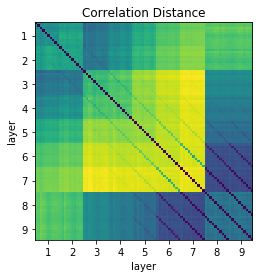

In [3]:
from matplotlib.pyplot import imshow
plt.title('Correlation Distance')
plt.xlabel('layer')
plt.xticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.yticks(ticks=[5, 15, 25, 35, 45, 55, 65, 75, 85],
           labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
plt.ylabel('layer')

plt.imshow(cca_correlations_distance)

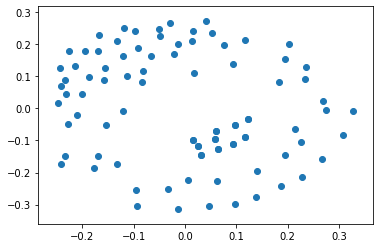

In [5]:
from sklearn.manifold import MDS
embedding = MDS(n_components=2, dissimilarity='precomputed')

X_transformed = embedding.fit_transform(cca_correlations_distance)
X_transformed.shape
plt.scatter(X_transformed[:, 0], X_transformed[:, 1])

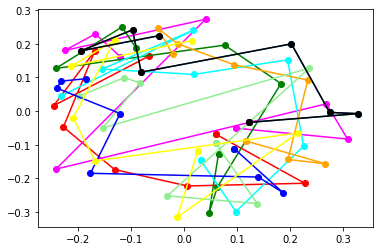

In [6]:
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', marker='o')
plt.plot(X_transformed[1::10, 0], X_transformed[1::10, 1], linestyle='-', marker='o', color='red')
plt.plot(X_transformed[2::10, 0], X_transformed[2::10, 1], linestyle='-', marker='o', color='magenta')
plt.plot(X_transformed[3::10, 0], X_transformed[3::10, 1], linestyle='-', marker='o', color='green')
plt.plot(X_transformed[4::10, 0], X_transformed[4::10, 1], linestyle='-', marker='o', color='cyan')
plt.plot(X_transformed[5::10, 0], X_transformed[5::10, 1], linestyle='-', marker='o', color='orange')
plt.plot(X_transformed[6::10, 0], X_transformed[6::10, 1], linestyle='-', marker='o', color='lightgreen')
plt.plot(X_transformed[7::10, 0], X_transformed[7::10, 1], linestyle='-', marker='o', color='blue')
plt.plot(X_transformed[8::10, 0], X_transformed[8::10, 1], linestyle='-', marker='o', color='yellow')
plt.plot(X_transformed[::10, 0], X_transformed[::10, 1], linestyle='-', marker='o', color='black')